In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import datetime
import h5py
import tensorflow as tf

In [3]:
DATA_PATH="D:/Project/GAN_CXR/NIH_chestxray14/image_metadata_raw.csv"
IMAGE_PATH="D:/NIH_chestxray14_images/images-224/"

In [4]:
xray_df = pd.read_csv(DATA_PATH)
images = {os.path.basename(x): x for x in glob(os.path.join(IMAGE_PATH, '*.png'))}
xray_df['Path'] = xray_df['Image Index'].map(images.get)
xray_df.drop(columns=['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'Unnamed: 11'], inplace=True)

xray_df['Finding Labels'] = xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

all_labels = list(np.unique(xray_df['Finding Labels'].str.split('|').explode().values))
all_labels = [label for label in all_labels if len(label)>0]
print (len(all_labels),all_labels)

for c_label in all_labels:
    xray_df[c_label] = xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0.0)
    
print (len(images),xray_df.shape)
print (xray_df.head())

14 ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
112120 (112120, 21)
        Image Index          Finding Labels  OriginalImage[Width  Height]  \
0  00000001_000.png            Cardiomegaly                 2682     2749   
1  00000001_001.png  Cardiomegaly|Emphysema                 2894     2729   
2  00000001_002.png   Cardiomegaly|Effusion                 2500     2048   
3  00000002_000.png                                         2500     2048   
4  00000003_000.png                  Hernia                 2582     2991   

   OriginalImagePixelSpacing[x     y]  \
0                        0.143  0.143   
1                        0.143  0.143   
2                        0.168  0.168   
3                        0.171  0.171   
4                        0.143  0.143   

                                                Path  Atelectasis  \
0  D:/NI

In [4]:
#we create a mini dataset for GAN

sample_weight_mini = xray_df['Finding Labels'].map(lambda x:len(x.split('|')) if len(x)>0 else 0.0).values +1e-1
sample_weight_mini/=sample_weight_mini.sum()
sampled_df=xray_df.sample(20000,weights=sample_weight_mini)

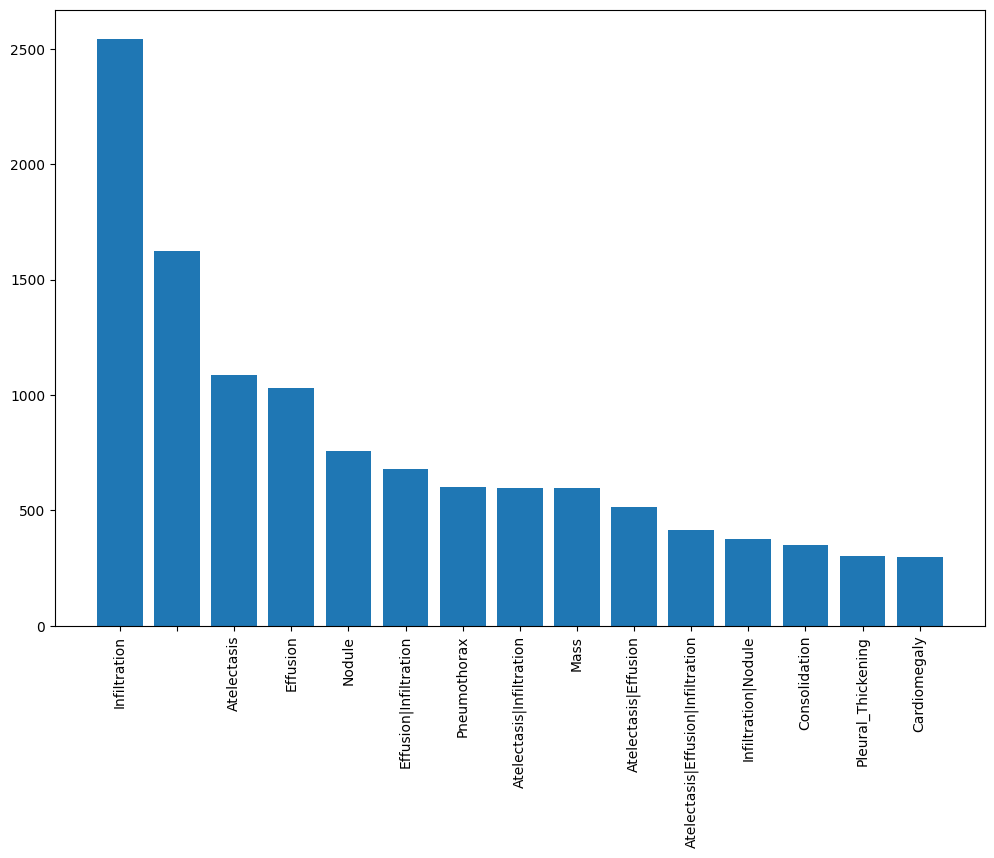

In [5]:
label_count_mini = sampled_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_count_mini))+0.5, label_count_mini)
ax1.set_xticks(np.arange(len(label_count_mini))+0.5)
_ = ax1.set_xticklabels(label_count_mini.index, rotation = 90)

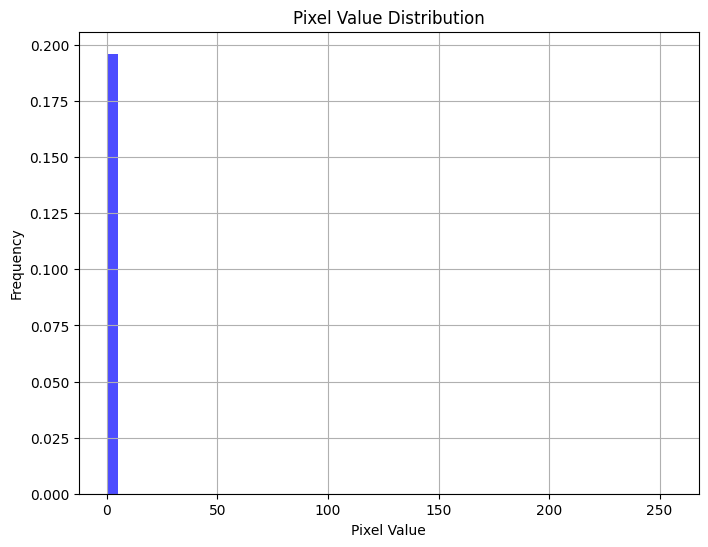

In [6]:
sample_image = plt.imread(sampled_df['Path'].iloc[0])  
pixel_values = sample_image.flatten()  
pixel_range = (0, 255)  

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(pixel_values, bins=50, range=pixel_range, density=True, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

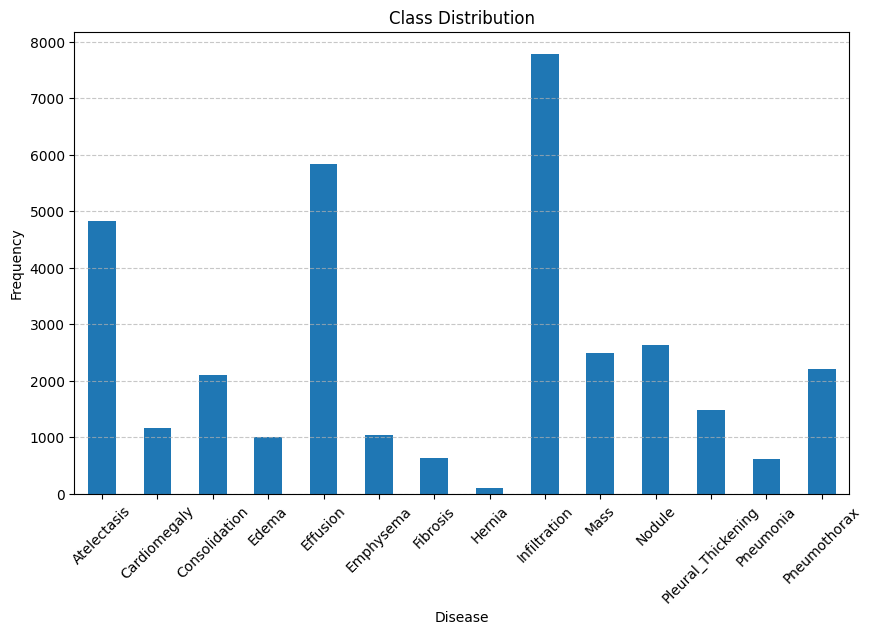

Class Frequencies:
Atelectasis           4827.0
Cardiomegaly          1158.0
Consolidation         2105.0
Edema                  999.0
Effusion              5843.0
Emphysema             1047.0
Fibrosis               640.0
Hernia                  96.0
Infiltration          7782.0
Mass                  2487.0
Nodule                2640.0
Pleural_Thickening    1481.0
Pneumonia              614.0
Pneumothorax          2205.0
dtype: float64


In [7]:
class_frequencies = sampled_df[all_labels].sum()

plt.figure(figsize=(10, 6))
class_frequencies.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print('Class Frequencies:')
print(class_frequencies)

In [8]:
#we create a hdf5 file of our mini dataset which will be used later
import h5py as h5py
from tqdm import tqdm

def write_df_as_hdf(out_path,out_df,compression='gzip'):
    with h5py.File(out_path,'w') as h:
        for k, arr_dict in tqdm(out_df.to_dict().items()):
            try:
                s_data = np.stack(arr_dict.values(),0)
                try:
                    h.create_dataset(k, data = s_data,compression = compression)
                except TypeError as e:
                    try:
                        h.create_dataset(k,data=s_data.astype(np.string_),compression=compression)
                    except TypeError as e2:
                        print ("%s could not be added to hdf5,%s" %(k,repr(e),repr(e2)))
                    
            except ValueError as e:
                print ('%s could not be created,%s' %(k,repr(e)))
                all_shape = [np.shape(x) for x in arr_dict.values()]
                print('Input shapes :{}'.format(all_shape))
                

In [9]:
write_df_as_hdf('chest_xray.h5',sampled_df)

  0%|          | 0/21 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 21/21 [00:00<00:00, 21.41it/s]


In [10]:
#reading the mini dataset
with h5py.File('chest_xray.h5','r') as h_data:
    for c_key in h_data.keys():
        print (c_key,h_data[c_key].shape,h_data[c_key].dtype)

Atelectasis (20000,) float64
Cardiomegaly (20000,) float64
Consolidation (20000,) float64
Edema (20000,) float64
Effusion (20000,) float64
Emphysema (20000,) float64
Fibrosis (20000,) float64
Finding Labels (20000,) |S100
Height] (20000,) int32
Hernia (20000,) float64
Image Index (20000,) |S16
Infiltration (20000,) float64
Mass (20000,) float64
Nodule (20000,) float64
OriginalImagePixelSpacing[x (20000,) float64
OriginalImage[Width (20000,) int32
Path (20000,) |S53
Pleural_Thickening (20000,) float64
Pneumonia (20000,) float64
Pneumothorax (20000,) float64
y] (20000,) float64


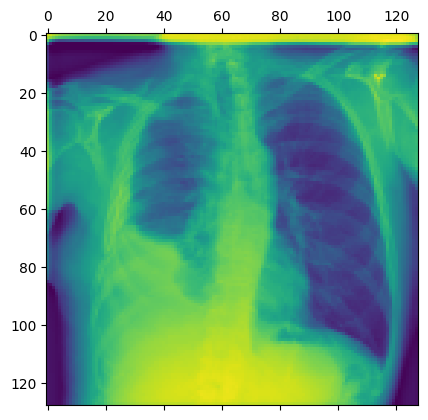

In [11]:
# preprocessing images using CLAHE algorithm as in kaggle kernel
from skimage.transform import resize
from cv2 import createCLAHE,imread
OUT_DIM = (128, 128)
clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def imread_and_normalize(im_path):
    img_data = np.mean(imread(im_path), 2).astype(np.uint8)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    return np.expand_dims(n_img, -1)


test_img = imread_and_normalize(sampled_df['Path'].values[0])
plt.matshow(test_img[:,:,0])


In [12]:
out_image_arr = np.zeros((sampled_df.shape[0],) + OUT_DIM+(1,),dtype=np.uint8)
if False:
    out_image_arr = np.random.uniform(0,255,size = (sampled_df.shape[0],)+OUT_DIM+(1,)).astype(np.uint8)

In [13]:
for i,c_path in enumerate(tqdm(sampled_df['Path'].values)):
    out_image_arr[i] = imread_and_normalize(c_path)

100%|██████████| 20000/20000 [02:26<00:00, 136.91it/s]


In [14]:
with h5py.File('chest_xray.h5','a') as h5_data:
    h5_data.create_dataset('images',data = out_image_arr,compression=None)
with h5py.File('chest_xray.h5','r') as h5_data:
    for c_key in h5_data.keys():
        print (c_key,h5_data[c_key].shape,h5_data[c_key].dtype)

Atelectasis (20000,) float64
Cardiomegaly (20000,) float64
Consolidation (20000,) float64
Edema (20000,) float64
Effusion (20000,) float64
Emphysema (20000,) float64
Fibrosis (20000,) float64
Finding Labels (20000,) |S100
Height] (20000,) int32
Hernia (20000,) float64
Image Index (20000,) |S16
Infiltration (20000,) float64
Mass (20000,) float64
Nodule (20000,) float64
OriginalImagePixelSpacing[x (20000,) float64
OriginalImage[Width (20000,) int32
Path (20000,) |S53
Pleural_Thickening (20000,) float64
Pneumonia (20000,) float64
Pneumothorax (20000,) float64
images (20000, 128, 128, 1) uint8
y] (20000,) float64


Prediction Model

In [5]:
min_cases =1000
all_labels = [c_label for c_label in all_labels if xray_df[c_label].sum() > min_cases]
print ('Clean Labels-{}'.format(len(all_labels)),all_labels)

Clean Labels-13 ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [6]:
sample_weights = xray_df['Finding Labels'].map(lambda x:len(x.split('|')) if len(x)>0 else 0).values +4e-2
sample_weights /= sample_weights.sum()

print (sample_weights)
sampled_df1 = xray_df.sample(20000,weights = sample_weights)

print (sampled_df1['Finding Labels'].value_counts()[:15])
print (sampled_df1[all_labels].values.shape)

[1.21676136e-05 2.38672420e-05 2.38672420e-05 ... 4.67985137e-07
 4.67985137e-07 4.67985137e-07]
Finding Labels
Infiltration                         2586
Atelectasis                          1120
Effusion                             1098
Nodule                                758
Effusion|Infiltration                 744
                                      737
Atelectasis|Infiltration              652
Pneumothorax                          626
Mass                                  573
Atelectasis|Effusion                  567
Atelectasis|Effusion|Infiltration     463
Consolidation                         371
Infiltration|Nodule                   365
Pleural_Thickening                    328
Cardiomegaly                          282
Name: count, dtype: int64
(20000, 13)


In [7]:
sampled_df1

,Image Index,Finding Labels,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Path,Atelectasis,Cardiomegaly,Consolidation,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
32953,00008626_021.png,,2500,2048,0.168,0.168,D:/NIH_chestxray14_images/images-224\00008626_...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39030,00010217_000.png,Nodule,2500,2048,0.168,0.168,D:/NIH_chestxray14_images/images-224\00010217_...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
57410,00014245_004.png,Infiltration,1626,1749,0.143,0.143,D:/NIH_chestxray14_images/images-224\00014245_...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
92723,00023142_001.png,Effusion,3056,2544,0.139,0.139,D:/NIH_chestxray14_images/images-224\00023142_...,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58387,00014436_004.png,Infiltration|Mass,2992,2991,0.143,0.143,D:/NIH_chestxray14_images/images-224\00014436_...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36661,00009652_004.png,Infiltration,2992,2991,0.143,0.143,D:/NIH_chestxray14_images/images-224\00009652_...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
68156,00016811_002.png,Infiltration,2048,2500,0.168,0.168,D:/NIH_chestxray14_images/images-224\00016811_...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
76806,00018865_026.png,Infiltration|Pleural_Thickening,2992,2991,0.143,0.143,D:/NIH_chestxray14_images/images-224\00018865_...,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
105397,00028317_013.png,Emphysema,3056,2544,0.139,0.139,D:/NIH_chestxray14_images/images-224\00028317_...,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
from skimage.transform import resize
import cv2
from cv2 import createCLAHE,imread

IMAGE_DIM = (96, 96)
clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def preprocess_image(im_path):
    img_data = imread(im_path, cv2.IMREAD_GRAYSCALE) 
    clahe_img = clahe_tool.apply(img_data)  
    resized_img = resize(clahe_img, IMAGE_DIM , mode='constant')  
    return np.expand_dims(resized_img, -1)  

sampled_df1['Preprocessed_Image'] = sampled_df1['Path'].apply(preprocess_image)

In [9]:
sampled_df1['Disease_Vec'] = sampled_df1.apply(lambda x:[x[all_labels].values],1).map(lambda x:x[0])
print (sampled_df1['Disease_Vec'])

32953     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
39030     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
57410     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
92723     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
58387     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...
                                ...                        
36661     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
68156     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
76806     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
105397    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
52658     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Disease_Vec, Length: 20000, dtype: object


In [10]:
sampled_df1.columns

Index(['Image Index', 'Finding Labels', 'OriginalImage[Width', 'Height]',
       'OriginalImagePixelSpacing[x', 'y]', 'Path', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'Preprocessed_Image',
       'Disease_Vec'],
      dtype='object')

In [11]:
from sklearn.utils.class_weight import compute_class_weight

labels = sampled_df1['Finding Labels'].str.split('|').explode().values
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(labels),y=labels)
# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict.pop(0)
class_weights_dict = {key - 1: value for key, value in class_weights_dict.items()}

In [12]:
# Create a dictionary to map class indices to labels
unique_labels=np.unique(labels)
index_to_label = {i: label for i, label in enumerate(unique_labels[1:])}

# Print the mapping of class indices to labels
for class_index, class_weight in class_weights_dict.items():
    print(f"Class index {class_index}: Label '{index_to_label[class_index]}' - Class weight {class_weight}")

Class index 0: Label 'Atelectasis' - Class weight 0.47169348064870453
Class index 1: Label 'Cardiomegaly' - Class weight 2.0710354609929076
Class index 2: Label 'Consolidation' - Class weight 1.0557339117859725
Class index 3: Label 'Edema' - Class weight 2.1844404548174747
Class index 4: Label 'Effusion' - Class weight 0.38966639978649587
Class index 5: Label 'Emphysema' - Class weight 2.208227465214761
Class index 6: Label 'Fibrosis' - Class weight 3.568132942326491
Class index 7: Label 'Hernia' - Class weight 29.318875502008034
Class index 8: Label 'Infiltration' - Class weight 0.30020560901389914
Class index 9: Label 'Mass' - Class weight 0.9524331376386171
Class index 10: Label 'Nodule' - Class weight 0.9120939530234883
Class index 11: Label 'Pleural_Thickening' - Class weight 1.5002877106452939
Class index 12: Label 'Pneumonia' - Class weight 3.8022916666666666
Class index 13: Label 'Pneumothorax' - Class weight 1.0539050093835716


In [13]:
x=sampled_df1['Preprocessed_Image']
y=sampled_df1[['Atelectasis','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
               'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',
               'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']]

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =0.2, shuffle=True, random_state=42)

In [15]:
x_train = np.array(x_train.tolist())
x_train = x_train / 255.0
x_test = np.array(x_test.tolist())
x_test = x_test / 255.0

In [16]:
y_train = y_train.values
y_test = y_test.values

In [19]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  (96,96,1), 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(14, activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_96 (Functio  (None, 3, 3, 1024)        3228288   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                7

In [20]:
from keras.callbacks import ModelCheckpoint,EarlyStopping, TensorBoard
weight_path = 'classification_model/model_weight_{}.hdf5'.format('xray_real')
checkpoint=ModelCheckpoint(weight_path,monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
tensorboard = TensorBoard(log_dir='Tensorboard/classification/training',histogram_freq=2)
callbacks_list = [checkpoint, early, tensorboard]


In [33]:
batch_size=32
history = multi_disease_model.fit(
    x_train,  # Training data
    y_train,  # Training labels
    batch_size=batch_size,
    epochs=10,
    validation_data=(x_test, y_test),  # Validation data
    callbacks=callbacks_list,
    class_weight=class_weights_dict
)

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.3936 - binary_accuracy: 0.8587 - mae: 0.2143
Epoch 1: val_loss improved from inf to 0.42804, saving model to classification_model\model_weight_xray_real.hdf5
500/500 [==============================] - 296s 564ms/step - loss: 0.3936 - binary_accuracy: 0.8587 - mae: 0.2143 - val_loss: 0.4280 - val_binary_accuracy: 0.8722 - val_mae: 0.1484
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.3366 - binary_accuracy: 0.8690 - mae: 0.2110
Epoch 2: val_loss improved from 0.42804 to 0.36624, saving model to classification_model\model_weight_xray_real.hdf5
500/500 [==============================] - 329s 658ms/step - loss: 0.3366 - binary_accuracy: 0.8690 - mae: 0.2110 - val_loss: 0.3662 - val_binary_accuracy: 0.8719 - val_mae: 0.1841
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.3295 - binary_accuracy: 0.8694 - mae: 0.2095
Epoch 3: val_loss did not improve from 0.36624
500/500 [=

In [34]:
multi_disease_model.save(filepath='classification_model/xray_model_real.keras')

In [17]:
import io

def plt_to_image(figure):
    # Save the plot to a PNG in memory
    buf = io.BytesIO()
    figure.savefig(buf, format='png')
    buf.seek(0)
    # Convert PNG buffer to TF image tensor
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add batch dimension
    image = tf.expand_dims(image, 0)
    # Close the buffer
    buf.close()
    return image

125/125 [==============================] - 17s 109ms/step
Atelectasis: Dx: 25.17%, PDx: 16.75%
Cardiomegaly: Dx: 6.17%, PDx: 11.59%
Consolidation: Dx: 10.80%, PDx: 17.12%
Edema: Dx: 5.65%, PDx: 14.68%
Effusion: Dx: 30.75%, PDx: 33.72%
Emphysema: Dx: 5.25%, PDx: 7.58%
Fibrosis: Dx: 3.45%, PDx: 5.11%
Infiltration: Dx: 0.60%, PDx: 3.25%
Mass: Dx: 41.77%, PDx: 34.24%
Nodule: Dx: 12.72%, PDx: 11.03%
Pleural_Thickening: Dx: 13.10%, PDx: 8.84%
Pneumonia: Dx: 7.52%, PDx: 8.27%
Pneumothorax: Dx: 3.40%, PDx: 5.57%


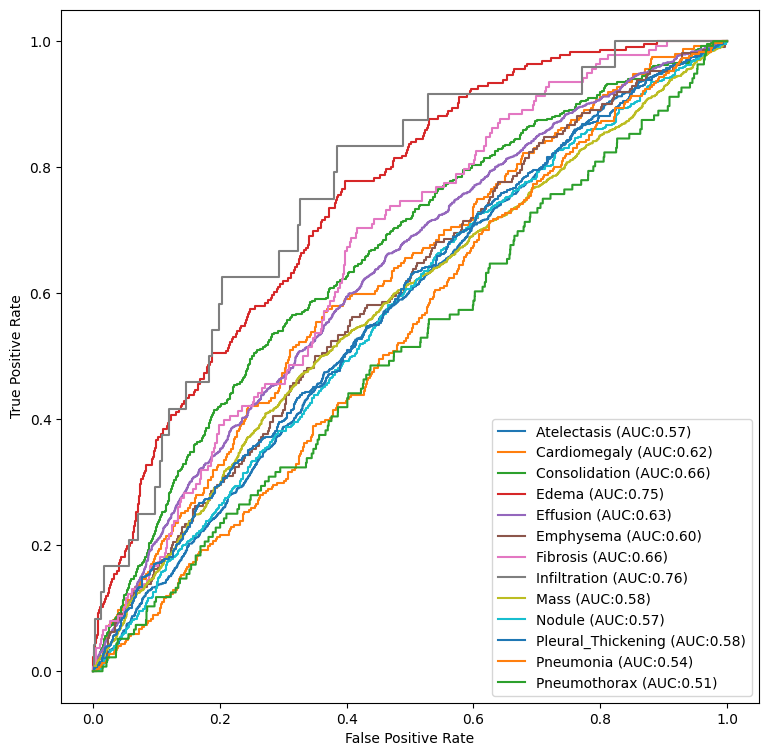

In [21]:
from sklearn.metrics import roc_curve, auc

# Load weights and predict
multi_disease_model.load_weights(weight_path)
pred_y = multi_disease_model.predict(x_test, batch_size=32)

# Calculate ROC AUC curve
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_y,0), 
                                     100*np.mean(y_test,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

fig_roc, c_ax_roc = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), pred_y[:, idx])
    c_ax_roc.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax_roc.legend()
c_ax_roc.set_xlabel('False Positive Rate')
c_ax_roc.set_ylabel('True Positive Rate')
roc_image = plt_to_image(fig_roc)

# Log evaluation metrics to TensorBoard
log_dir = 'Tensorboard/classification/evaluation'
# Log all metrics and visualizations to TensorBoard
with tf.summary.create_file_writer(log_dir).as_default():
    # Log ROC AUC curve image
    tf.summary.image('ROC_AUC_Curve', roc_image, step=0)